<a href="https://colab.research.google.com/github/suchig/Hotel-Reviews/blob/master/Hotel_Review_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

from scipy.sparse import hstack, csr_matrix

!pip install   xgboost
import xgboost as xgb
from xgboost import XGBRegressor

import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

!pip install hyperopt
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp;

---
# Initialization of data
Read the Hotel reviews csv file and examine its structure and information


In [129]:
hotels = pd.read_csv("Hotel_Reviews.csv")
print(hotels.shape)
print(hotels.info())

(515738, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738

Note above that several features are String/Object. We will have to convert this to numeric datatypes. 
1. Address, we know that Country is the most important aspect in the same. So we strip Off Country, categorize it as numeric. (We will remove Address later)
2. Convert Review_Date to numeric
3. Categorize Reviewer_Nationality to numeric
4. Convert Days_since_review to numeric

In [0]:
split_address = hotels['Hotel_Address'].str.split()
items = [item[-1] for item in split_address]

hotels["Country"], country_unique = pd.factorize(items)

hotels["Review_Date"] = hotels["Review_Date"].str.replace('/','')
hotels["Review_Date"] = hotels["Review_Date"].astype(int)

hotels["Reviewer_Nationality"], reviewer_nationality_unique = hotels['Reviewer_Nationality'].factorize()

split_days = hotels['days_since_review'].str.split()
items = [int(item[0]) for item in split_days]
hotels['days_since_review']=items

---
# Classification of reviews

This section deals with creating a classification model to train and infer positive_reviews and negative reviews . To do this structure of data has to be modified from

```
Row 1 -> Feature 1, ....Positive_Review 1, Negative Review 1,....
Row 2 -> Feature 2, ....Positive_Review 2, Negative Review 2,....
Row 3 -> Feature 3, ....Positive_Review 3, Negative Review 3,....
....
```

to the below structure
```
Row 1 -> Positive_Review 1, Rating Positive
Row 2 -> Positive_Review 2, Rating Positive
Row 3 -> Positive_Review 3, Rating Positive
Row 4 -> Negative Review 1, Rating Negative
Row 5 -> Negative Review 2, Rating Negative
Row 6 -> Negative Review 3, Rating Negative
....
```

In [0]:
neg_reviews = pd.DataFrame(data = hotels[hotels['Negative_Review']!='No Negative']
                           [['Negative_Review']])
neg_reviews.rename(columns={"Negative_Review": "review"},inplace=True)
neg_reviews['rating']=0

pos_reviews = pd.DataFrame(hotels[hotels['Positive_Review']!='No Positive']
                           [['Positive_Review']])
pos_reviews.rename(columns={"Positive_Review": "review"},inplace=True)
pos_reviews['rating']=1

reviews=pd.concat([pos_reviews,neg_reviews])

Split as test and train

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews['review'], reviews['rating'], test_size=0.3, random_state=27)

In order to classify, positive and negative reviews have to be cleaned, segmented and lemmatized. After the same, CountVectorizer and TFIDTransformer will convert the reviews into tfid values.

In [0]:
lemmatizer = WordNetLemmatizer()
#remove punctuations
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

#method to split sentences to lemmatized words
def normalize(text):
    tokens = nltk.word_tokenize(text.lower().translate(remove_punct_dict))
    return [lemmatizer.lemmatize(token) for token in tokens]

In [135]:
nltk.download('punkt')
nltk.download('wordnet')
count_vectorizer = CountVectorizer(tokenizer=normalize, stop_words='english')
tfid_transformer = TfidfTransformer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


X_train values are converted to Count Vector values using Count vector's fit_transform.
Count Vector values are converted to TFID values using TFI Transformer's fit_transformer.
These are fed as training X values to a classifier model, in this case, NaiveBayes Classifier (MultinomialNB)

In [0]:
count_X_train = count_vectorizer.fit_transform(X_train.values.astype(str).ravel())
tfid_X_train = tfid_transformer.fit_transform(count_X_train)
classifier = MultinomialNB()
classifier_train = classifier.fit(tfid_X_train,y_train)

Now with the trained model, y values are predicted for x and accuracy is calculated. It comes to about 88%. 

In [137]:
count_X_test = count_vectorizer.transform(X_test.values.astype(str).ravel())
tfid_X_test = tfid_transformer.fit_transform(count_X_test)
classifier_y_pred = classifier_train.predict(tfid_X_test)
accuracy_score(y_test,classifier_y_pred)

0.8821592672844344

The same is repeated with SGDClassifier to see if it can have better prediction. This gives 91% which is a good improvement.

In [138]:
svm = SGDClassifier()
svm_train = svm.fit(tfid_X_train,y_train)
svm_y_pred = svm_train.predict(tfid_X_test)
accuracy_score(y_test,svm_y_pred)

0.9110959998770611



---

# Frequent words
Top 25 words that influenced the training set are identified in Positive and Negative sets and plotted

In [0]:
def get_most_freq(X,vector,n):
  avg_features = X.mean(axis=0)
  words_list = ((word, avg_features[0, i], i) for word, i in vector.vocabulary_.items())

  return sorted(words_list, key = lambda x: x[1], reverse=True)[:n]

In [140]:
tfid_train_pos = tfid_X_train[np.where(y_train==1)]
tfid_train_neg = tfid_X_train[np.where(y_train==0)]

pos_freq_words_train = get_most_freq(tfid_train_pos,count_vectorizer,25)
neg_freq_words_train = get_most_freq(tfid_train_neg,count_vectorizer,25)

print(pos_freq_words_train)
print(neg_freq_words_train)

[('location', 0.1116727041521233, 33911), ('staff', 0.07695186378704567, 52669), ('wa', 0.06050451547296505, 60301), ('good', 0.05450659944028772, 26268), ('great', 0.051394990991526834, 26591), ('room', 0.050109041211201154, 47888), ('friendly', 0.04551272509801534, 24858), ('hotel', 0.03969004085155618, 28607), ('breakfast', 0.0388015948419023, 10008), ('helpful', 0.03828147400291981, 27859), ('excellent', 0.03619182985192731, 22042), ('clean', 0.03579722832309442, 13057), ('nice', 0.035239671808480824, 38482), ('comfortable', 0.03242613445893197, 13901), ('bed', 0.03201368844016861, 8391), ('lovely', 0.019578894116930447, 34313), ('perfect', 0.016542494479584863, 41769), ('comfy', 0.015834952970642295, 13964), ('service', 0.015318574451937756, 49752), ('close', 0.014906400662035945, 13334), ('station', 0.013894057706280629, 52938), ('really', 0.013410865897529652, 45300), ('amazing', 0.013401908822838982, 5100), ('stay', 0.012884747941664141, 52986), ('quiet', 0.012537990985674602, 

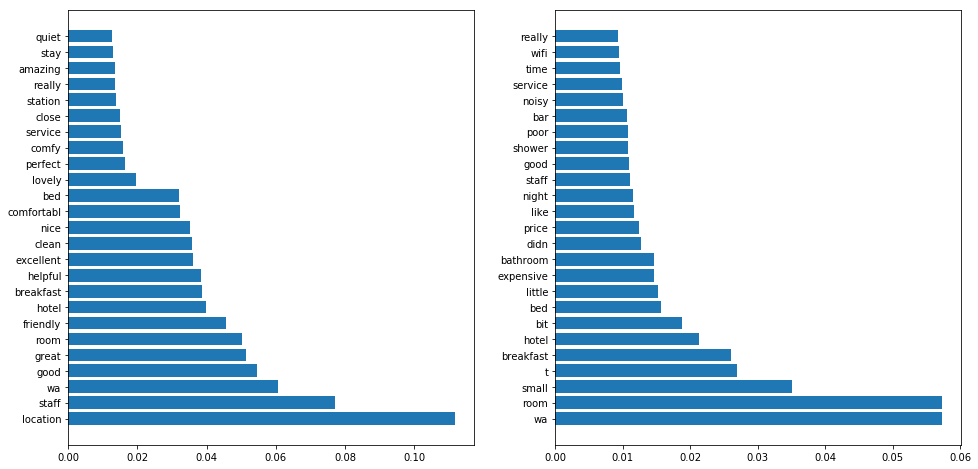

In [141]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,2,1)
ar_pos_freq_words = np.array(pos_freq_words_train,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
pos_width = ar_pos_freq_words['c']
pos_words = ar_pos_freq_words['w']
ax.barh(np.arange(25),pos_width);
ax.set_yticks(np.arange(25))
ax.set_yticklabels(pos_words);
ax=fig.add_subplot(1,2,2)
ar_neg_freq_words = np.array(neg_freq_words_train,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
neg_width = ar_neg_freq_words['c']
neg_words = ar_neg_freq_words['w']
ax.barh(np.arange(25),neg_width);
ax.set_yticks(np.arange(25))
ax.set_yticklabels(neg_words);

---
# Regression of Hotel data
This section will assess the average score of Hotel data using the TFID values and other hotel features. In order to do that, both Positive and Negative reviews are combined since the average score is influence by the overall review. TFID values are retrieved for this combined review


In [0]:
hotels[hotels['Negative_Review']=='No Negative']['Negative_Review']=''
hotels[hotels['Positive_Review']=='No Positive']['Positive_Review']=''
total_review = pd.DataFrame()
total_review['review'] = hotels['Positive_Review']+hotels['Negative_Review']

In [0]:
count_total = count_vectorizer.fit_transform(total_review['review'])
tfid_total = tfid_transformer.fit_transform(count_total)

A function is defined to train a XGBoost model for the training data. R2 and MSE are calculated. And a residual plot is drawn.

DMatrix is used to enable faster processing of sparse matrix 

In [0]:
def fit_and_infer(X_train,y_train,X_test,y_test):
  xgb_train = xgb.DMatrix(X_train,label=y_train)
  xgb_x_test = xgb.DMatrix(X_test,label=y_test)
  
  xgb_params = {
      'verbosity' : 0
  }
  watchlist = [(xgb_train, 'train'), (xgb_x_test, 'test')]
  num_round = 500
  
  clf = xgb.train(xgb_params, xgb_train, num_round, watchlist,verbose_eval=50)
  y_pred = clf.predict(xgb_x_test)
  print("r2 :",r2_score(y_test,y_pred))
  print("mse :",mean_squared_error(y_test,y_pred))
  
  plt.figure(figsize=(10,6))
  plt.scatter(y_test,y_pred);
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r',lw=4);

**TFID values and hotel Average Score**

TFID values are treated as X and Average Score of hotel data is treated as Y. The data is split as train and test.
The values are scaled before running through regressor

[0]	train-rmse:5.55499	test-rmse:5.5538
[50]	train-rmse:0.497676	test-rmse:0.505984
[100]	train-rmse:0.487672	test-rmse:0.500692
[150]	train-rmse:0.481284	test-rmse:0.498356
[200]	train-rmse:0.476477	test-rmse:0.496899
[250]	train-rmse:0.47257	test-rmse:0.496147
[300]	train-rmse:0.469199	test-rmse:0.495657
[350]	train-rmse:0.466263	test-rmse:0.495258
[400]	train-rmse:0.46375	test-rmse:0.49508
[450]	train-rmse:0.461367	test-rmse:0.494925
[499]	train-rmse:0.459157	test-rmse:0.494825
r2 : 0.18743541680292808
mse : 0.24485220708185834


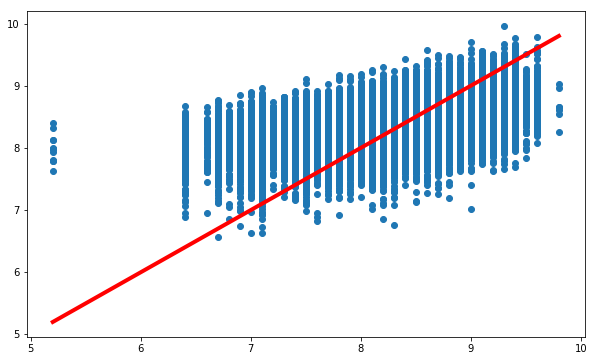

In [160]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_total, hotels['Average_Score'],random_state=27)

sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )


**Top 25 TFID values and Average Score**

The next option to check is if there is any difference if only top 25 TFID values are used to predict Average score

[0]	train-rmse:5.55507	test-rmse:5.55379
[50]	train-rmse:0.524443	test-rmse:0.531814
[100]	train-rmse:0.521003	test-rmse:0.532251
[150]	train-rmse:0.517884	test-rmse:0.532725
[200]	train-rmse:0.514627	test-rmse:0.533292
[250]	train-rmse:0.511746	test-rmse:0.533829
[300]	train-rmse:0.509154	test-rmse:0.534171
[350]	train-rmse:0.506911	test-rmse:0.534639
[400]	train-rmse:0.504418	test-rmse:0.535054
[450]	train-rmse:0.501978	test-rmse:0.535477
[499]	train-rmse:0.499729	test-rmse:0.5359
r2 : 0.0469372678119343
mse : 0.28718888109244245


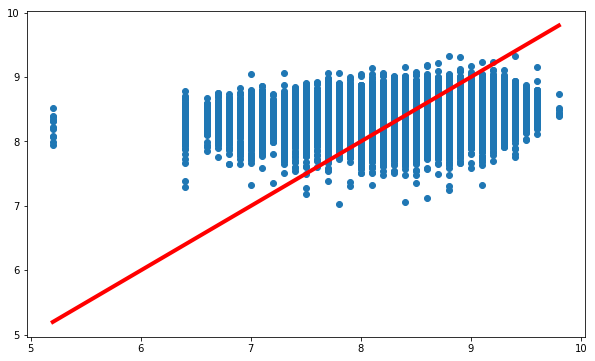

In [159]:
top_freq_words = get_most_freq(tfid_total,count_vectorizer,25)
ar_top_freq_words = np.array(top_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
words_sparse = tfid_total[:,ar_top_freq_words['i']]

sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    words_sparse, hotels['Average_Score'],random_state=27)

sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )


**Hotel features with TFID values**

There are other features in the hotel data that could be used along with TFID values for prediction. Looking at r2 values of above predictions, it looks like using entire set of TFID values will give a better prediction than restricted set (of 25 top values). 

In order to do the same, hotel data has to be cleaned. 

- Some of the string values are already converted to numeric
- Lattitude and Longitide can be removed (assumption that this may not make a lot of difference)
- Positive_review and Negative_Review can be removed since TFID values will be introduced
- Hotel Address can be dropped since Country attribute is retained
- Tags are removed now (Maybe used later depending on value derived from Tags)

In [0]:
hotels[hotels["lat"].isnull()]["lat"]=0
hotels[hotels["lng"].isnull()]["lng"]=0

[0]	train-rmse:5.55184	test-rmse:5.55061
[50]	train-rmse:0.25299	test-rmse:0.254542
[100]	train-rmse:0.187008	test-rmse:0.190758
[150]	train-rmse:0.144463	test-rmse:0.149074
[200]	train-rmse:0.126897	test-rmse:0.132435
[250]	train-rmse:0.111508	test-rmse:0.118198
[300]	train-rmse:0.097372	test-rmse:0.104819
[350]	train-rmse:0.095055	test-rmse:0.103177
[400]	train-rmse:0.088669	test-rmse:0.097194
[450]	train-rmse:0.080127	test-rmse:0.089153
[499]	train-rmse:0.075487	test-rmse:0.084822
r2 : 0.9761233437162202
mse : 0.007194815168803019


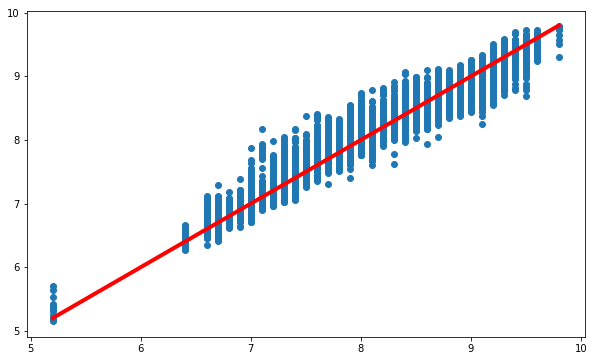

In [167]:
hotels_edited = hotels.drop(
    ['Hotel_Address','Average_Score','Hotel_Name','Negative_Review','Positive_Review','Tags','lat','lng'],axis=1)
hotels_sparse = hstack(
    (csr_matrix(hotels_edited.loc[np.arange(0,hotels_edited.shape[0]),:].values), 
     tfid_total))
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotels_sparse, hotels['Average_Score'],random_state=27)
sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

As seen above, XGB regression with hotel features as well as TFID values give an impressive output with r2 of 0.97.